In [38]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [39]:
import pandas as pd
pd.set_option('display.max_columns', None )
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, precision_score, recall_score, f1_score, classification_report, make_scorer

from datetime import datetime

rd = np.random.seed(1973)

import catboost as ctb
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

import scikitplot as skplt

import matplotlib.pyplot as plt

In [40]:
df_train = pd.read_hdf("../input/train_churn_pred.h5")
df_test = pd.read_hdf("../input/test_churn_pred.h5")
df_train.shape, df_test.shape

((34999, 171), (35000, 170))

In [41]:
df_train.head()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
3,3,0.00,0.00,0.00,30,31,31,94.62,138.82,129.23,57.54,93.08,79.73,48.03,110.00,90.96,0.00,0.00,0.00,0.00,0.00,0.00,8.54,2.36,39.03,26.71,71.78,77.13,0.00,0.26,2.94,0.00,0.00,0.00,35.26,74.41,119.12,48.99,90.71,40.69,21.31,37.93,10.88,0.00,0.00,0.00,0.00,0.00,0.00,70.31,128.64,51.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,105.58,203.06,170.69,6.21,3.33,15.78,7.24,18.01,41.99,0.00,0.00,0.00,13.46,21.34,57.78,1.11,23.53,1.48,0.00,2.56,13.03,0.00,0.00,0.00,0.00,0.00,0.00,1.11,26.09,14.51,14.96,76.58,72.29,0.00,0.00,0.00,0.00,29.13,0.00,0.38,0.00,0.00,3,2,5,120,120,310,120,120,130,6/20/2014,7/16/2014,8/26/2014,120,0,130,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,389,0.00,0.00,0.00,0
6,6,0.00,0.00,0.00,30,31,31,139.13,183.02,225.31,57.96,45.86,62.86,170.83,213.25,167.69,0.00,0.00,0.00,0.00,0.00,0.00,57.96,45.86,62.86,124.48,116.79,146.06,7.28,2.85,3.38,0.00,0.00,0.00,189.73,165.51,212.25,0.00,0.00,0.00,0.00,0.00,1.35,39.06,93.59,16.06,0.00,0.00,0.00,39.06,93.59,17.41,0.00,0.00,0.28,0.00,0.00,0.55,0.00,0.00,0.00,228.79,259.11,230.56,47.24,68.09,61.09,71.31,122.88,171.34,21.64,27.03,53.61,140.21,218.01,286.06,0.00,0.00,0.00,0.00,0.00,1.53,1.18,4.68,3.54,0.00,0.00,0.00,1.18,4.68,5.08,141.48,222.69,291.21,0.00,0.00,0.00,0.08,0.00,0.06,0.00,0.00,0.00,2,2,3,158,140,371,128,110,144,6/22/2014,7/31/2014,8/26/2014,1

In [42]:
#df_train.info(verbose=True, memory_usage='deep')

In [43]:
feats_object = df_train.select_dtypes('object').columns.to_list()

train = df_train.copy()
test = df_test.copy()

In [44]:
feats_object

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [45]:
for feat in feats_object:
    train[feat] = pd.to_datetime(train[feat], format="%m/%d/%Y")
    test[feat] = pd.to_datetime(test[feat], format="%m/%d/%Y")

In [46]:
train['date_of_last_rech_6_year'] = train['date_of_last_rech_6'].apply(lambda x: x.year)
train['date_of_last_rech_7_year'] = train['date_of_last_rech_7'].apply(lambda x: x.year)
train['date_of_last_rech_8_year'] = train['date_of_last_rech_8'].apply(lambda x: x.year)

train['date_of_last_rech_6_month'] = train['date_of_last_rech_6'].apply(lambda x: x.month)
train['date_of_last_rech_7_month'] = train['date_of_last_rech_7'].apply(lambda x: x.month)
train['date_of_last_rech_8_month'] = train['date_of_last_rech_8'].apply(lambda x: x.month)

train['date_of_last_rech_6_day'] = train['date_of_last_rech_6'].apply(lambda x: x.day)
train['date_of_last_rech_7_day'] = train['date_of_last_rech_7'].apply(lambda x: x.day)
train['date_of_last_rech_8_day'] = train['date_of_last_rech_8'].apply(lambda x: x.day)

test['date_of_last_rech_6_year'] = test['date_of_last_rech_6'].apply(lambda x: x.year)
test['date_of_last_rech_7_year'] = test['date_of_last_rech_7'].apply(lambda x: x.year)
test['date_of_last_rech_8_year'] = test['date_of_last_rech_8'].apply(lambda x: x.year)

test['date_of_last_rech_6_month'] = test['date_of_last_rech_6'].apply(lambda x: x.month)
test['date_of_last_rech_7_month'] = test['date_of_last_rech_7'].apply(lambda x: x.month)
test['date_of_last_rech_8_month'] = test['date_of_last_rech_8'].apply(lambda x: x.month)

test['date_of_last_rech_6_day'] = test['date_of_last_rech_6'].apply(lambda x: x.day)
test['date_of_last_rech_7_day'] = test['date_of_last_rech_7'].apply(lambda x: x.day)
test['date_of_last_rech_8_day'] = test['date_of_last_rech_8'].apply(lambda x: x.day)

feats_to_ignore = [x for x in train.columns.to_list() if train[x].nunique() == 1  ]
feats_to_ignore = (feats_to_ignore + ['id'] + feats_object)

feats = [x for x in train.columns.to_list() if x not in feats_to_ignore]
feats_X = feats.copy()
feats.remove('churn_probability')
feats.append('churn_probability')
feats_X.remove('churn_probability')

In [47]:
feats

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

In [48]:
feats_X

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

### fillna() for train and test

In [49]:
# train
# list of feats with NaNs
feats_nan_train = [ x[0] for x in train[feats_X].isna().sum().to_dict().items() if x[1] > 0 ]

# only feats with 'arpu' has NaN
feats_arpu_train = [x for x in train[feats_nan_train].columns.to_list() if 'arpu' in x]
train.fillna(-2, inplace=True)

#test 
# list of feats with NaNs
feats_nan_test = [ x[0] for x in test[feats_X].isna().sum().to_dict().items() if x[1] > 0 ]

# only feats with 'arpu' has NaN
feats_arpu_test = [x for x in test[feats_nan_test].columns.to_list() if 'arpu' in x]
test.fillna(-1, inplace=True)

In [50]:
# train[feats].hist(figsize=(60,50), bins=50);

In [51]:
# train['arpu_avg'] = (train['arpu_6'] + train['arpu_7'] + train['arpu_8']) / 3
# test['arpu_avg'] = (test['arpu_6'] + test['arpu_7'] + test['arpu_8']) / 3

# feats = feats + ['arpu_avg']
# feats_X = feats_X + ['arpu_avg']

# X_train = train[feats]
# X_test = test[feats_X]

In [52]:
train[["total_rech_amt_6", "av_rech_amt_data_6", "total_rech_data_6"]] = train[["total_rech_amt_6", "av_rech_amt_data_6", "total_rech_data_6"]].astype(float)
test[["total_rech_amt_6", "av_rech_amt_data_6", "total_rech_data_6"]] = test[["total_rech_amt_6", "av_rech_amt_data_6", "total_rech_data_6"]].astype(float)

In [53]:
# Compute the Average total recharge amount of each customer in 6 and 7 month 

Total_recharge_amount_6 = train["total_rech_amt_6"] + (train["av_rech_amt_data_6"] / 100) * train["total_rech_data_6"]

Total_recharge_amount_7 = train["total_rech_amt_7"] + (train["av_rech_amt_data_7"] / 100) * train["total_rech_data_7"]

Total_recharge_amount_8 = train["total_rech_amt_8"] + (train["av_rech_amt_data_8"] / 100)* train["total_rech_data_8"]

Total_recharge_amount_6and7 = Total_recharge_amount_6 + Total_recharge_amount_7

Avg_recharge_amount_6and7 = Total_recharge_amount_6and7 / 2

In [54]:
train['Total_recharge_amount_6'] = Total_recharge_amount_6
train['Total_recharge_amount_7'] = Total_recharge_amount_7
train['Total_recharge_amount_8'] = Total_recharge_amount_8

train['Avg_recharge_amount_6and7'] = Avg_recharge_amount_6and7 

In [55]:
np.percentile(Avg_recharge_amount_6and7, 80)

484.03999999955295

In [56]:
# Compute the Average total recharge amount of each customer in 6 and 7 month 

Total_recharge_amount_6 = test["total_rech_amt_6"] + (test["av_rech_amt_data_6"] / 100) * test["total_rech_data_6"]

Total_recharge_amount_7 = test["total_rech_amt_7"] + (test["av_rech_amt_data_7"] / 100) * test["total_rech_data_7"]

Total_recharge_amount_8 = test["total_rech_amt_8"] + (test["av_rech_amt_data_8"] / 100) * test["total_rech_data_8"]

Total_recharge_amount_6and7 = Total_recharge_amount_6 + Total_recharge_amount_7

Avg_recharge_amount_6and7 = Total_recharge_amount_6and7 / 2

In [57]:
test['Total_recharge_amount_6'] = Total_recharge_amount_6
test['Total_recharge_amount_7'] = Total_recharge_amount_7
test['Total_recharge_amount_8'] = Total_recharge_amount_8

test['Avg_recharge_amount_6and7'] = Avg_recharge_amount_6and7 

In [58]:
feats = feats + ['Total_recharge_amount_6', 'Total_recharge_amount_7', 'Total_recharge_amount_8', 'Avg_recharge_amount_6and7']
feats_X = feats_X + ['Total_recharge_amount_6', 'Total_recharge_amount_7', 'Total_recharge_amount_8', 'Avg_recharge_amount_6and7']

X_train = train[feats]
X_test = test[feats_X]

In [59]:
X_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,churn_probability,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
3,94.62,138.82,129.23,57.54,93.08,79.73,48.03,110.00,90.96,0.00,0.00,0.00,0.00,0.00,0.00,8.54,2.36,39.03,26.71,71.78,77.13,0.00,0.26,2.94,0.00,0.00,0.00,35.26,74.41,119.12,48.99,90.71,40.69,21.31,37.93,10.88,0.00,0.00,0.00,70.31,128.64,51.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,105.58,203.06,170.69,6.21,3.33,15.78,7.24,18.01,41.99,0.00,0.00,0.00,13.46,21.34,57.78,1.11,23.53,1.48,0.00,2.56,13.03,0.00,0.00,0.00,1.11,26.09,14.51,14.96,76.58,72.29,0.00,0.00,0.00,0.00,29.13,0.00,0.38,0.00,0.00,3,2,5,120.00,120,310,120,120,130,120,0,130,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,0,0,0,0,0,0,0,0,0,0,0,0,-2.00,-2.00,-2.00,389,0.00,0.00,0.00,20.00,16.00,26.00,0,120.04,120.04,310.04,120.04
6,139.13,183.02,225.31,57.96,45.86,62.86,170.83,213.25,167.69,0.00,0.00,0.00,0.00,0.00,0.00,57.96,45.86,62.86,124.48,116.79,146.06,7.28,2.85,3.38,0.00,0.00,0.00,189.73,165.51,212.25,0.00,0.00,0.00,0.00,0.00,1.35,39.06,93.59,16.06,39.06,93.59,17.41,0.00,0.00,0.28,0.00,0.00,0.55,0.00,0.00,0.00,228.79,259.11,230.56,47.24,68.09,61.09,71.31,122.88,171.34,21.64,27.03,53.61,140.21,218.01,286.06,0.00,0.00,0.00,0.00,0.00,1.53,1.18,4.68,3.54,1.18,4.68,5.08,141.48,222.69,291.21,0.00,0.00,0.00,0.08,0.00,0.06,0.00,0.00,0.00,2,2,3,158.00,140,371,128,110,144,128,30,130,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,0,0,0,0,0,0,0,0,0,0,0,0,-2.00,-2.00,-2.00,2456,0.00,0.00,0.00,22.00,31.0

In [60]:
X_test.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,11.20,673.00,578.09,0.00,17.28,26.96,11.43,258.00,332.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.59,10.39,11.43,248.21,274.46,0.00,0.43,0.00,0.00,9.11,0.58,11.43,251.24,284.75,0.00,14.68,16.56,0.00,0.23,57.36,0.00,0.00,0.00,0.00,14.91,73.93,0.00,0.00,0.00,0.00,10.19,3.33,0.00,0.00,0.00,11.43,276.36,362.13,0.00,0.00,0.00,1.43,184.51,164.18,0.00,0.00,0.00,1.43,184.51,164.18,0.00,10.88,29.54,0.00,1.14,0.00,0.00,0.00,0.00,0.00,12.03,29.54,1.43,196.54,193.94,0.00,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00,1,10,12,0.00,361,724,0,110,154,0,30,130,-1.00,4.00,1.00,-1.00,252.00,154.00,-1.00,3.00,1.00,-1.00,1.00,0.00,-1.00,348.00,154.00,0.00,22.92,48.07,0.00,"1,211.00",751.29,-1.00,14.59,0.00,-1.00,0.00,0.00,-1.00,0.00,0.00,0,0,1,0,3,0,0,1,0,0,0,0,-1.00,1.00,1.00,302,383.17,"1,007.10",0.00,12.00,25.00,28.00,0.01,374.92,725.54,187.47
1,165.91,251.36,254.20,70.96,40.46,41.04,135.31,128.12,66.24,0.00,41.06,0.00,0.00,29.06,0.00,70.61,20.41,41.04,130.69,28.43,58.98,0.00,0.00,0.00,0.00,0.00,2.95,201.31,48.84,100.00,0.35,0.00,0.00,4.61,0.00,1.81,0.00,0.00,0.00,4.96,0.00,1.81,0.00,0.00,0.00,0.00,90.74,5.45,0.00,0.00,0.00,206.28,139.59,107.29,114.51,38.54,100.48,158.63,52.78,64.83,10.46,6.06,3.01,283.61,97.39,168.33,0.00,0.00,0.00,2.88,0.51,5.76,0.00,1.11,2.16,2.88,1.63,7.93,286.49,99.03,176.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,4,8,230.00,220,285,120,120,130,110,100,130,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0,0,0,0,0,0,0,0,0,0,0,0,-1.00,-1.00,-1.00,634,0.00,0.00,0.00,30.00,29.00,28.00,230.01,220.01,285.

In [61]:
r = X_test.index[np.isinf(X_test).any(1)]
print(r)

Int64Index([], dtype='int64')


In [62]:
np.isinf(X_test).values.sum()

0

In [63]:
X_test.loc[48201:48203]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
48201,112.57,138.99,232.39,7.58,13.91,1.04,101.49,53.50,18.99,0.00,0.00,0.00,0.00,0.00,0.00,7.58,11.84,1.04,78.44,47.64,9.48,7.43,0.33,0.00,1.05,0.00,7.30,93.46,59.83,10.53,0.00,2.06,0.00,9.19,2.01,0.45,5.36,3.51,1.76,14.56,7.59,2.21,0.00,0.00,0.00,1.05,1.88,7.30,0.00,0.00,0.00,109.08,69.31,20.04,13.18,10.96,4.71,80.09,51.51,40.53,0.00,0.00,2.61,93.28,62.48,47.86,0.00,0.00,0.00,0.28,1.74,18.23,25.96,31.03,12.31,26.24,32.78,30.54,119.64,95.26,78.41,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,3,6,4,0.00,271,204,0,128,154,0,0,0,-1.00,-1.00,1.00,-1.00,-1.00,154.00,-1.00,-1.00,1.00,-1.00,-1.00,0.00,-1.00,-1.00,154.00,0.00,0.00,3.14,0.00,0.00,45.68,-1.00,-1.00,82.64,-1.00,-1.00,0.00,-1.00,-1.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,-1.00,-1.00,1.00,2218,26.49,2.15,0.00,27.00,25.00,24.00,0.01,271.01,205.54,135.51
48202,96.79,63.01,98.58,31.04,17.73,16.79,54.88,41.94,23.54,0.00,0.00,0.00,0.00,0.00,0.00,31.04,17.73,16.79,54.88,41.94,23.54,0.00,0.00,0.00,0.00,0.00,0.00,85.93,59.68,40.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.36,0.00,3.09,0.00,0.00,0.00,90.29,59.68,43.44,4.48,26.76,46.99,17.23,43.98,49.11,0.00,1.13,0.00,21.71,71.88,96.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.78,71.88,96.11,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,4,5,7,120.00,60,145,30,30,30,30,0,30,-1.00,-1.00,1.00,-1.00,-1.00,25.00,-1.00,-1.00,1.00,-1.00,-1.00,0.00,-1.00,-1.00,25.00,0.00,0.00,1.60,0.00,0.00,127.76,-1.00,-1.00,4.64,-1.00,-1.00,0.00,-1.00,-1.00,0.00,0,0,0,0,0,1,0,0,0,0,0,0,-1.00,-1.00,1.00,1231,0.00,0.00,0.00,29.00,25.00,31.00,120.01,60.01,145.25,90.01
48203,"1,237.23","1,513.85","6,255.09",524.

### normalization

In [65]:
from sklearn.preprocessing import RobustScaler

# create a scaler object
scaler = RobustScaler()

# fit and transform the data
train_robust = pd.DataFrame(scaler.fit_transform(train[feats_X]), columns=feats_X)

train_robust.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,-0.37,-0.19,-0.22,0.24,0.60,0.50,-0.22,0.13,0.04,0.00,0.00,0.00,0.00,0.00,0.00,-0.05,-0.22,0.79,-0.11,0.36,0.43,0.00,0.14,1.65,0.00,0.00,0.00,-0.17,0.11,0.42,1.78,3.19,1.61,0.38,0.71,0.20,0.00,0.00,0.00,0.46,0.86,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.12,0.18,0.10,-0.19,-0.27,0.04,-0.39,-0.31,-0.09,-0.09,-0.09,-0.09,-0.41,-0.37,-0.15,0.31,6.34,0.43,-0.11,0.07,0.84,0.00,0.00,0.00,-0.15,0.80,0.39,-0.47,-0.19,-0.20,0.00,0.00,0.00,0.00,29.13,0.00,0.38,0.00,0.00,-0.50,-0.57,0.00,-0.33,-0.30,0.24,0.11,0.10,0.28,0.82,-0.27,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.35,0.00,0.00,0.00,-0.78,-1.38,-0.17,-0.34,-0.30,0.24,-0.36
1,-0.21,-0.03,0.12,0.25,0.15,0.34,0.42,0.67,0.45,0.00,0.00,0.00,0.00,0.00,0.00,1.26,0.96,1.44,0.88,0.83,1.14,3.96,1.50,1.90,0.00,0.00,0.00,0.87,0.73,1.06,0.00,0.00,0.00,-0.06,-0.06,-0.01,39.06,93.59,16.06,0.22,0.61,0.08,0.00,0.00,0.28,0.00,0.00,0.16,0.00,0.00,0.00,0.25,0.35,0.28,0.77,1.29,1.13,0.18,0.63,1.05,2.75,3.41,7.29,0.31,0.78,1.17,0.00,0.00,0.00,-0.11,-0.11,0.01,1.18,4.68,3.54,-0.15,-0.01,0.02,0.13,0.52,0.84,0.00,0.00,0.00,0.08,0.00,0.06,0.00,0.00,0.00,-0.67,-0.57,-0.33,-0.21,-0.24,0.42,0.20,0.00,0.40,0.89,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.18,0.00,0.00,0.00,-0.56,0.50,-0.17,-0.22,-0.24,0.41,-0.27
2,-0.52,0

In [66]:
# transform the test data
test_robust = pd.DataFrame(scaler.transform(test[feats_X]), columns=feats_X)

test_robust.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,-0.67,1.73,1.35,-0.28,-0.12,-0.01,-0.40,0.90,1.32,0.00,0.00,0.00,0.00,0.00,0.00,-0.28,-0.21,0.01,-0.27,2.19,2.47,0.00,0.23,0.00,0.00,9.11,0.58,-0.33,1.32,1.55,0.00,0.52,0.66,-0.06,-0.05,1.22,0.00,0.00,0.00,-0.07,0.04,0.52,0.00,0.00,0.00,0.00,3.14,0.98,0.00,0.00,0.00,-0.41,0.40,0.67,-0.33,-0.35,-0.34,-0.44,1.19,0.99,-0.09,-0.09,-0.09,-0.47,0.58,0.46,0.00,2.93,8.61,-0.11,-0.03,-0.10,0.00,0.00,0.00,-0.20,0.27,0.99,-0.53,0.39,0.38,0.00,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00,-0.83,0.57,1.17,-0.70,0.43,1.44,-1.22,0.00,0.49,-0.27,0.00,0.77,0.33,2.00,1.00,0.33,13.37,8.21,0.50,2.50,1.50,0.50,1.50,1.00,0.25,18.42,6.24,0.00,22.92,48.07,0.00,"1,211.00",751.29,1.00,8.30,1.00,1.00,1.00,1.00,0.50,1.00,1.00,0.00,0.00,1.00,0.00,3.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.50,1.50,1.50,-0.42,383.17,"1,007.10",0.00,-1.67,-0.25,0.17,-0.70,0.47,1.43,-0.14
1,-0.11,0.21,0.22,0.37,0.10,0.12,0.23,0.22,-0.09,0.00,41.06,0.00,0.00,29.06,0.00,1.60,0.27,0.84,0.94,-0.09,0.24,0.00,0.00,0.00,0.00,0.00,2.95,0.95,-0.07,0.29,0.01,0.00,0.00,0.04,-0.06,-0.00,0.00,0.00,0.00,-0.03,-0.07,-0.04,0.00,0.00,0.00,0.00,27.92,1.60,0.00,0.00,0.00,0.19,-0.01,-0.09,2.35,0.58,2.07,0.95,0.00,0.11,1.28,0.69,0.32,1.12,0.07,0.49,0.00,0.00,0.00,0.10,-0.07,0.31,0.00,1.11,2.16,-0.08,-0.13,0.13,0.82,-0.08,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.67,-0.29,0.50,0.01,0.00,0.17,0.11,0.10,0.28,0.73,0.64,0.77,0.33,0.33,0.33,0.33,0.05,0.05,0.50,0.50,0.50,0.50,0.50,0.50,0.25,0.05,0.04,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50,0.50,1.00,0.50,0.50,0.50,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.50,-0.17,0.00,0.00,0.00,0.33,0.25,0.17,-0.00,-0.00,0

In [67]:
# train_robust.hist(figsize=(60,50), bins=50);

### transformation

In [68]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method = 'yeo-johnson')

'''
parameters:
method = 'box-cox' or 'yeo-johnson'
'''

train_transf = pd.DataFrame(scaler.fit_transform(train_robust), columns=feats_X)
train_transf.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,-0.72,-0.38,-0.42,0.28,0.71,0.61,-0.58,0.16,0.01,-0.16,-0.10,-0.05,-0.18,-0.11,-0.06,-0.32,-0.84,0.89,-0.35,0.50,0.58,-0.38,-0.21,0.73,-0.11,-0.13,-0.10,-0.48,0.13,0.58,1.29,1.55,1.22,0.33,0.74,-0.06,-0.03,-0.02,0.02,0.51,0.94,0.32,0.10,0.09,0.14,-0.41,-0.51,-0.48,-0.08,0.17,0.20,-0.35,0.23,0.10,-0.64,-0.88,-0.03,-1.10,-0.81,-0.23,-0.74,-0.75,-0.70,-1.11,-0.98,-0.36,0.06,1.69,0.21,-0.84,-0.25,0.87,-0.11,-0.11,-0.07,-0.79,0.89,0.47,-1.21,-0.40,-0.43,0.01,0.06,0.10,-0.08,1.96,-0.06,0.31,-0.04,0.00,-0.85,-1.32,-0.05,-0.62,-0.58,0.37,0.55,0.55,0.58,1.13,-1.11,1.24,-0.58,-0.59,-0.60,-0.58,-0.58,-0.59,-0.58,-0.59,-0.60,-0.58,-0.59,-0.60,-0.58,-0.59,-0.59,-0.52,-0.53,-0.53,-0.41,-0.43,-0.43,-0.33,-0.43,-0.36,-0.38,-0.45,-0.34,-0.58,-0.59,-0.60,-0.28,-0.29,-0.28,-0.39,-0.40,-0.41,-0.25,-0.25,-0.26,-0.21,-0.21,-0.21,-0.58,-0.59,-0.60,-1.04,-0.44,-0.44,-0.42,-0.92,-1.39,-0.24,-0.62,-0.58,0.37,-0.75
1,-0.43,-0.11,0.18,0.29,0.12,0.41,0.55,0.78,0.58,-0.16,-0.10,-0.05,-0.18,-0.11,-0.06,1.16,1.00,1.24,0.97,0.94,1.13,1.31,0.73,0.82,-0.11,-0.13,-0.10,0.96,0.86,1.09,-0.70,-0.70,-0.68,-0.82,-0.82,-0.68,3.57,4.46,2.78,0.09,0.70,-0.32,0.10,0.09,0.39,-0.41,-0.51,-0.17,-0.08,0.17,0.20,0.35,0.47,0.38,0.89,1.18,1.11,0.26,0.78,1.08,1.49,1.58,1.80,0.45,0.88,1.14,-0.50,-0.51,-0.45,-0.84,-0.84,-0.42,0.57,1.36,1.16,-0.78,-0.34,-0.25,0.20,0.66,0.94,0.01,0.06,0.10,-0.02,-0.10,-0.01,-0.03,-0.04,0.00,-1.27,-1.32,-0.67,-0.37,-0.44,0.57,0.63,0.44,0.71,1.20,-0.05,1.24,-0.58,-0.59,-0.60,-0.58,-0.58,-0.59,-0.58,-0.59,-0.60,-0.58,-0.59,-0.60,-0.58,-0.59,-0.59,-0.52,-0.53,-0.53,-0.41,-0.43,-0.43,-0.33,-0.43,-0.36,-0.38,-0.45,-0.34,-0.58,-0.59,-0.60,-0.28,-0.29,-0.

In [69]:
# train_transf.hist(figsize=(60,50), bins=50);

In [70]:
test_transf = pd.DataFrame(scaler.transform(test_robust), columns=feats_X)
test_transf.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,-1.34,1.44,1.25,-1.15,-0.54,-0.24,-1.18,0.95,1.18,-0.16,-0.10,-0.05,-0.18,-0.11,-0.06,-1.09,-0.82,-0.16,-0.82,1.51,1.58,-0.38,-0.11,-0.33,-0.11,2.01,0.28,-0.99,1.21,1.32,-0.70,0.46,0.62,-0.82,-0.80,1.09,-0.03,-0.02,0.02,-0.86,-0.43,0.59,0.10,0.09,0.14,-0.41,1.43,0.68,-0.08,0.17,0.20,-1.23,0.53,0.80,-1.17,-1.18,-1.16,-1.29,1.15,1.04,-0.74,-0.75,-0.70,-1.35,0.72,0.62,-0.50,1.37,1.75,-0.84,-0.55,-0.81,-0.11,-0.11,-0.07,-0.97,0.28,1.02,-1.43,0.53,0.53,0.01,0.06,0.59,-0.08,-0.10,-0.06,-0.03,-0.04,0.00,-1.74,0.78,1.04,-1.59,0.56,1.31,-1.63,0.44,0.79,-1.21,-0.05,1.24,1.07,1.78,1.60,0.04,1.88,1.84,1.23,1.78,1.66,1.40,1.74,1.63,-0.10,1.83,1.76,-0.52,1.92,1.97,-0.41,2.37,2.33,-0.00,1.61,0.16,0.03,0.43,-0.04,1.50,1.70,1.66,-0.28,-0.29,3.54,-0.39,2.55,-0.41,-0.25,4.07,-0.26,-0.21,-0.21,-0.21,1.33,1.70,1.68,-1.25,2.29,2.34,-0.42,-1.50,-0.44,0.26,-1.59,0.59,1.31,-0.26
1,-0.28,0.24,0.32,0.46,0.03,0.06,0.32,0.30,-0.26,-0.16,2.19,-0.05,-0.18,1.84,-0.06,1.29,0.34,0.93,1.01,-0.30,0.34,-0.38,-0.39,-0.33,-0.11,-0.13,1.07,1.01,-0.23,0.42,-0.65,-0.70,-0.68,-0.47,-0.82,-0.64,-0.03,-0.02,0.02,-0.70,-0.85,-0.77,0.10,0.09,0.14,-0.41,2.17,1.00,-0.08,0.17,0.20,0.25,-0.11,-0.30,1.52,0.72,1.45,1.01,-0.03,0.16,1.09,0.69,0.24,1.12,0.09,0.64,-0.50,-0.51,-0.45,-0.17,-0.71,0.27,-0.11,0.54,0.86,-0.54,-0.72,0.02,0.91,-0.16,0.43,0.01,0.06,0.10,-0.08,-0.10,-0.06,-0.03,-0.04,0.00,-1.27,-0.53,0.55,0.03,0.01,0.28,0.55,0.55,0.58,1.05,1.05,1.24,1.07,0.99,0.94,0.04,-0.36,-0.38,1.23,1.16,1.11,1.40,1.35,1.30,-0.10,-0.40,-0.44,-0.52,-0.53,-0.53,-0.41,-0.43,-0.43,-0.00,0.11,-0.05,0.03,0.10,-0.17,1.50,1.45,1.41,-0.28,-0.29,-0.28,-0.39,-0.40,-0.41,-0.25,-0.25,-0.26,-0.21,-0.

### X_train, y_train, X_test

In [71]:
train_transf.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,-0.72,-0.38,-0.42,0.28,0.71,0.61,-0.58,0.16,0.01,-0.16,-0.10,-0.05,-0.18,-0.11,-0.06,-0.32,-0.84,0.89,-0.35,0.50,0.58,-0.38,-0.21,0.73,-0.11,-0.13,-0.10,-0.48,0.13,0.58,1.29,1.55,1.22,0.33,0.74,-0.06,-0.03,-0.02,0.02,0.51,0.94,0.32,0.10,0.09,0.14,-0.41,-0.51,-0.48,-0.08,0.17,0.20,-0.35,0.23,0.10,-0.64,-0.88,-0.03,-1.10,-0.81,-0.23,-0.74,-0.75,-0.70,-1.11,-0.98,-0.36,0.06,1.69,0.21,-0.84,-0.25,0.87,-0.11,-0.11,-0.07,-0.79,0.89,0.47,-1.21,-0.40,-0.43,0.01,0.06,0.10,-0.08,1.96,-0.06,0.31,-0.04,0.00,-0.85,-1.32,-0.05,-0.62,-0.58,0.37,0.55,0.55,0.58,1.13,-1.11,1.24,-0.58,-0.59,-0.60,-0.58,-0.58,-0.59,-0.58,-0.59,-0.60,-0.58,-0.59,-0.60,-0.58,-0.59,-0.59,-0.52,-0.53,-0.53,-0.41,-0.43,-0.43,-0.33,-0.43,-0.36,-0.38,-0.45,-0.34,-0.58,-0.59,-0.60,-0.28,-0.29,-0.28,-0.39,-0.40,-0.41,-0.25,-0.25,-0.26,-0.21,-0.21,-0.21,-0.58,-0.59,-0.60,-1.04,-0.44,-0.44,-0.42,-0.92,-1.39,-0.24,-0.62,-0.58,0.37,-0.75
1,-0.43,-0.11,0.18,0.29,0.12,0.41,0.55,0.78,0.58,-0.16,-0.10,-0.05,-0.18,-0.11,-0.06,1.16,1.00,1.24,0.97,0.94,1.13,1.31,0.73,0.82,-0.11,-0.13,-0.10,0.96,0.86,1.09,-0.70,-0.70,-0.68,-0.82,-0.82,-0.68,3.57,4.46,2.78,0.09,0.70,-0.32,0.10,0.09,0.39,-0.41,-0.51,-0.17,-0.08,0.17,0.20,0.35,0.47,0.38,0.89,1.18,1.11,0.26,0.78,1.08,1.49,1.58,1.80,0.45,0.88,1.14,-0.50,-0.51,-0.45,-0.84,-0.84,-0.42,0.57,1.36,1.16,-0.78,-0.34,-0.25,0.20,0.66,0.94,0.01,0.06,0.10,-0.02,-0.10,-0.01,-0.03,-0.04,0.00,-1.27,-1.32,-0.67,-0.37,-0.44,0.57,0.63,0.44,0.71,1.20,-0.05,1.24,-0.58,-0.59,-0.60,-0.58,-0.58,-0.59,-0.58,-0.59,-0.60,-0.58,-0.59,-0.60,-0.58,-0.59,-0.59,-0.52,-0.53,-0.53,-0.41,-0.43,-0.43,-0.33,-0.43,-0.36,-0.38,-0.45,-0.34,-0.58,-0.59,-0.60,-0.28,-0.29,-0.

In [72]:
train_transf.shape

(34999, 158)

In [73]:
test_transf.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day,Total_recharge_amount_6,Total_recharge_amount_7,Total_recharge_amount_8,Avg_recharge_amount_6and7
0,-1.34,1.44,1.25,-1.15,-0.54,-0.24,-1.18,0.95,1.18,-0.16,-0.10,-0.05,-0.18,-0.11,-0.06,-1.09,-0.82,-0.16,-0.82,1.51,1.58,-0.38,-0.11,-0.33,-0.11,2.01,0.28,-0.99,1.21,1.32,-0.70,0.46,0.62,-0.82,-0.80,1.09,-0.03,-0.02,0.02,-0.86,-0.43,0.59,0.10,0.09,0.14,-0.41,1.43,0.68,-0.08,0.17,0.20,-1.23,0.53,0.80,-1.17,-1.18,-1.16,-1.29,1.15,1.04,-0.74,-0.75,-0.70,-1.35,0.72,0.62,-0.50,1.37,1.75,-0.84,-0.55,-0.81,-0.11,-0.11,-0.07,-0.97,0.28,1.02,-1.43,0.53,0.53,0.01,0.06,0.59,-0.08,-0.10,-0.06,-0.03,-0.04,0.00,-1.74,0.78,1.04,-1.59,0.56,1.31,-1.63,0.44,0.79,-1.21,-0.05,1.24,1.07,1.78,1.60,0.04,1.88,1.84,1.23,1.78,1.66,1.40,1.74,1.63,-0.10,1.83,1.76,-0.52,1.92,1.97,-0.41,2.37,2.33,-0.00,1.61,0.16,0.03,0.43,-0.04,1.50,1.70,1.66,-0.28,-0.29,3.54,-0.39,2.55,-0.41,-0.25,4.07,-0.26,-0.21,-0.21,-0.21,1.33,1.70,1.68,-1.25,2.29,2.34,-0.42,-1.50,-0.44,0.26,-1.59,0.59,1.31,-0.26
1,-0.28,0.24,0.32,0.46,0.03,0.06,0.32,0.30,-0.26,-0.16,2.19,-0.05,-0.18,1.84,-0.06,1.29,0.34,0.93,1.01,-0.30,0.34,-0.38,-0.39,-0.33,-0.11,-0.13,1.07,1.01,-0.23,0.42,-0.65,-0.70,-0.68,-0.47,-0.82,-0.64,-0.03,-0.02,0.02,-0.70,-0.85,-0.77,0.10,0.09,0.14,-0.41,2.17,1.00,-0.08,0.17,0.20,0.25,-0.11,-0.30,1.52,0.72,1.45,1.01,-0.03,0.16,1.09,0.69,0.24,1.12,0.09,0.64,-0.50,-0.51,-0.45,-0.17,-0.71,0.27,-0.11,0.54,0.86,-0.54,-0.72,0.02,0.91,-0.16,0.43,0.01,0.06,0.10,-0.08,-0.10,-0.06,-0.03,-0.04,0.00,-1.27,-0.53,0.55,0.03,0.01,0.28,0.55,0.55,0.58,1.05,1.05,1.24,1.07,0.99,0.94,0.04,-0.36,-0.38,1.23,1.16,1.11,1.40,1.35,1.30,-0.10,-0.40,-0.44,-0.52,-0.53,-0.53,-0.41,-0.43,-0.43,-0.00,0.11,-0.05,0.03,0.10,-0.17,1.50,1.45,1.41,-0.28,-0.29,-0.28,-0.39,-0.40,-0.41,-0.25,-0.25,-0.26,-0.21,-0.

In [74]:
test_transf.shape

(35000, 158)

In [75]:
X_train = train_transf.values
y_train = train["churn_probability"].values

X_test  = test_transf.values 

### cal_metrics

In [76]:
def cal_metrics(y_test, y_pred):
    return {
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": fbeta_score(y_test, y_pred, beta=1.0),
        "f1.5": fbeta_score(y_test, y_pred, beta=1.5),
    }

### custom scorer

In [77]:
f_b1_5_scorer = make_scorer(fbeta_score, beta=1.5)

### cv = StratifiedKFold

In [78]:
cv = StratifiedKFold(n_splits=3)
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

# scores_prec = cross_val_score(model, X_train, y_train, cv=cv, scoring="precision")
# print("precision :", np.mean(scores_prec), np.std(scores_prec))

# scores_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")
# print("recall :", np.mean(scores_recall), np.std(scores_recall))

# scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
# print("f1 :", np.mean(scores_f1), np.std(scores_f1))

scores_fb1_5 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f_b1_5_scorer)
print("f1.5 :", np.mean(scores_fb1_5), np.std(scores_fb1_5))


f1.5 : 0.6482933521408524 0.005461029513778632


fbeta_1.5: 0.65


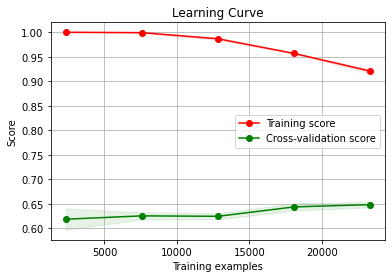

In [79]:
cv = StratifiedKFold(n_splits=3)

model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

def custom_score_cv(model, cv=cv, beta=1.5):
       
    f_beta_scorer = make_scorer(fbeta_score, beta=beta)
    
#     scores_prec = cross_val_score(model, X_train, y_train, cv=cv, scoring="precision")
#     scores_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")
#     scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    scores_fbeta = cross_val_score(model, X_train, y_train, cv=cv, scoring=f_beta_scorer)

#     prec = np.mean(scores_prec)
#     print("Precision: {:,.2f}".format(prec))
    
#     recall = np.mean(scores_recall)
#     print("Recall: {:,.2f}".format(recall))
    
#     f1 = np.mean(scores_f1)
#     print("f1: {:,.2f}".format(f1))
    
    f_beta = np.mean(scores_fbeta)
    print("fbeta_{}: {:,.2f}".format(beta, f_beta))
       
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring=f_beta_scorer, random_state=rd)
    
    return None

custom_score_cv(model=model, cv=cv, beta=1.5)

In [80]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
df_test["churn_probability"] = y_pred

df_test["churn_probability"].value_counts()

0    32178
1     2822
Name: churn_probability, dtype: int64

### scale_pos_weight ==> XGBoost

In [81]:
scale_pos_weights = int(df_train["churn_probability"].value_counts()[0] / df_train["churn_probability"].value_counts()[1])
scale_pos_weights

8

In [82]:
f_b1_5_scorer = make_scorer(fbeta_score, beta=1.5)

cv = StratifiedKFold(n_splits=3)

model_pos = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, scale_pos_weight=scale_pos_weights, random_state=rd)

scores = cross_val_score(model_pos, X_train, y_train, cv=cv, scoring=f_b1_5_scorer)

np.mean(scores), np.std(scores)

(0.7110676687157699, 0.009939193609199074)

In [35]:
custom_score_cv(model=model_pos, cv=cv, beta=1.5)

In [36]:
scale_pos = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for pos in scale_pos:
    model_pos = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, scale_pos_weight=pos, random_state=rd)
    scores = cross_val_score(model_pos, X_train, y_train, cv=cv, scoring=f_b1_5_scorer)
    print('pos :', pos, " --- ", np.mean(scores), np.std(scores))

pos : 1  ---  0.6416432626134188 0.002662457003207215
pos : 2  ---  0.6799767366678507 0.008563792502452768
pos : 3  ---  0.6934702727237888 0.006395273941480789
pos : 4  ---  0.6969050051350488 0.00574733787660434
pos : 5  ---  0.7056638422900504 0.008056900925687073
pos : 6  ---  0.7100894928310503 0.009210568080042114
pos : 7  ---  0.7063164399958817 0.00696494336697708
pos : 8  ---  0.7022312093751616 0.011140979682498983
pos : 9  ---  0.7062919052214602 0.010108371012119805
pos : 10  ---  0.709950066197291 0.011518370668535961
pos : 11  ---  0.7085056073430064 0.005934522648323273
pos : 12  ---  0.707215982177225 0.009563205364868798
pos : 13  ---  0.7107451490784081 0.005372744099542383
pos : 14  ---  0.7063526635741217 0.014626171744426052
pos : 15  ---  0.7039939571587007 0.011683015490626987


In [83]:
def custom_score_cv_pos(pos, cv=cv, beta=1.5):
    
    model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, scale_pos_weight=pos, random_state=rd)
       
    f_beta_scorer = make_scorer(fbeta_score, beta=beta)
    
    scores_prec = cross_val_score(model, X_train, y_train, cv=cv, scoring="precision")
    scores_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")
    scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    scores_fbeta = cross_val_score(model, X_train, y_train, cv=cv, scoring=f_beta_scorer)

    prec = np.mean(scores_prec)
    recall = np.mean(scores_recall)
    f1 = np.mean(scores_f1)
    f_beta = np.mean(scores_fbeta)
    
    print("Precision: {:,.2f}".format(prec))
    print("Recall: {:,.2f}".format(recall))
    print("f1: {:,.2f}".format(f1))
    print("fbeta_{}: {:,.2f}".format(beta, f_beta))
          
    return None

In [38]:
scale_pos = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for pos in scale_pos:
    print('pos = ', pos)
    custom_score_cv_pos(pos, cv=cv, beta=1.5)
    print('\n')

pos =  1
Precision: 0.74
Recall: 0.61
f1: 0.67
fbeta_1.5: 0.64


pos =  2
Precision: 0.71
Recall: 0.67
f1: 0.69
fbeta_1.5: 0.68


pos =  3
Precision: 0.68
Recall: 0.70
f1: 0.69
fbeta_1.5: 0.69


pos =  4
Precision: 0.67
Recall: 0.71
f1: 0.69
fbeta_1.5: 0.70


pos =  5
Precision: 0.65
Recall: 0.73
f1: 0.69
fbeta_1.5: 0.71


pos =  6
Precision: 0.64
Recall: 0.75
f1: 0.69
fbeta_1.5: 0.71


pos =  7
Precision: 0.63
Recall: 0.75
f1: 0.68
fbeta_1.5: 0.71


pos =  8
Precision: 0.62
Recall: 0.75
f1: 0.68
fbeta_1.5: 0.70


pos =  9
Precision: 0.61
Recall: 0.76
f1: 0.68
fbeta_1.5: 0.71


pos =  10
Precision: 0.60
Recall: 0.77
f1: 0.68
fbeta_1.5: 0.71


pos =  11
Precision: 0.60
Recall: 0.77
f1: 0.68
fbeta_1.5: 0.71


pos =  12
Precision: 0.59
Recall: 0.78
f1: 0.67
fbeta_1.5: 0.71


pos =  13
Precision: 0.59
Recall: 0.78
f1: 0.67
fbeta_1.5: 0.71


pos =  14
Precision: 0.58
Recall: 0.78
f1: 0.67
fbeta_1.5: 0.71


pos =  15
Precision: 0.58
Recall: 0.78
f1: 0.66
fbeta_1.5: 0.70




### model fit and predict

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
df_test["churn_probability"] = y_pred

df_test["churn_probability"].value_counts()

In [ ]:
## model z scale_pos_weights 

model_pos = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, scale_pos_weight=8, random_state=rd)

model_pos.fit(X_train, y_train)

y_pred = model_pos.predict(X_test)
df_test["churn_probability"] = y_pred

df_test["churn_probability"].value_counts()

In [ ]:
df_test[ ["id", "churn_probability"] ].to_csv("../output/xgb_dummy2.csv", index=False)

### experiments

In [84]:
X_train = train_transf.values
y_train = train["churn_probability"].values

X_test  = test[feats_X].values 

In [85]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3):    
     
    X_train = train[feats_X].values
    y_train = train["churn_probability"].values
    
    f1_5_scorer = make_scorer(fbeta_score, beta=1.5)

    scores = []
    cv=StratifiedKFold(n_splits=n_splits)                                 #shuffle=True, random_state=0
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        
        #y_pred = model.predict(X_train[test_idx])

        print(classification_report(y_train[test_idx], y_pred))
        
        skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred, normalize=True)
        skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)
    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring="f1", random_state=rd)

In [ ]:
model = model
make_experiment(model)

In [ ]:
make_experiment(model, threshold=0.2 )

In [ ]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, random_state=rd)
make_experiment(model, threshold=0.2)

In [ ]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, random_state=rd)
make_experiment(model, threshold=0.2, n_splits=10)

In [ ]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, random_state=rd)
make_experiment(model, threshold=0.1, n_splits=10,)

In [ ]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, scale_pos_weight=9, random_state=rd)
make_experiment(model, threshold=0.2, n_splits=10,)

In [ ]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, scale_pos_weight=9, random_state=rd)
make_experiment(model, threshold=0.1, n_splits=10)

In [ ]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3):    
     
    X_train = train[feats_X].values
    y_train = train["churn_probability"].values
    
    f1_5_scorer = make_scorer(fbeta_score, beta=1.5)

    scores = []
    cv=StratifiedKFold(n_splits=n_splits)                                 #shuffle=True, random_state=0
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        
        #y_pred = model.predict(X_train[test_idx])

        print(classification_report(y_train[test_idx], y_pred))
        
        skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred, normalize=True)
        skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = fbeta_score(y_train[test_idx], y_pred, beta=1.5)
#         score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)
    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring=f1_5_scorer, random_state=rd)

In [ ]:
model = model
make_experiment(model)

In [ ]:
make_experiment(model, threshold=0.2 )

In [ ]:
make_experiment(model, threshold=0.1 )